# Part 2
## Encoding weights, finding $U_w$,  inner products, and classification

Inspired by work by Francesco Tacchino, Chiara Macchiavello, Dario Gerace & Daniele Bajoni https://www.nature.com/articles/s41534-019-0140-4?amp%3Bcode=4cf1b507-7e23-4df0-a2a1-e82a3fe2bc4b

In [1]:
import math
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, BasicAer, Aer
from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_bloch_multivector

We'll again make use of the sign-flip algorithm from last time, with slight modificiations. This time, it will not begin each circuit with parallel Hadamard gates and will output 3 qubit circuits with 2 qubits plus an ancillary quibit.

In [2]:
def SF_encoder(i):
    """
        Parameters:
            - i (list) A classical binary valued {-1, 1} input vector
        Returns:
            - circ (qiskit.circuit.quantumcircuit.QuantumCircuit) A quantum 3 qubit circuit that 
              properly encodes the input vector i
        Description:
            - convert vector to binary string, or somehow generate computatinal basis vectors    
            - Apply SF algorithm whenver there is a negative -1 in i
            - Use -1 position to indentify corresponding computational basis, sandwich qubits
              in the 0 state with X gates, and in-between apply a CZ
    """
    
    i = np.array(i)
    d = len(i) # dimesionality of input vector
    
    # Validate input
    assert math.log(d, 2)%1 == 0, "Invalid vector length. Must be 2^N"
    
    N = int(math.log(d, 2)) # number of qubits
    
    # Generate computational basis (standard basis) vectors with Dirac labeling
    Dirac_vectors = [("{:0%db}"%N).format(k) for k in range(d)]
    
    '''
    for b in Dirac_vectors:
        print(b)
    '''
    
    # create quantum register and circuit (N+1 for the ancilla qubit)
    q = QuantumRegister(N+1, 'q')
    c = ClassicalRegister(1, 'c')
    circ = QuantumCircuit(q, c)
    
    # removed Hadamard gates
    
    # Find all components with a -1 factor in i (and thus our target state vector)
    indices = np.where(i == -1)[0]
    if indices.size > 0:
        for idx in indices:
            # Need to switch qubits in the 0 state so CZ will take effect
            for i, b in enumerate(Dirac_vectors[idx]):
                if b == '0':
                    circ.x(q[(N-1)-i]) # (N-1)-i is to match the qubit ordering Qiskit uses (reversed)
                    
            circ.cz(q[0], q[1]) # this is the only part that doesn't generalize for N!=2

            # And switch the flipped qubits back
            for i, b in enumerate(Dirac_vectors[idx]):
                if b == '0':
                    circ.x(q[(N-1)-i])
            
    return circ

def k2vec(k, m=4):
    """
        Parameters: 
            - k (integer) the integer number for the corresponding binary vector
            - m (integer) the length of binary string (needed to distinguish all possibilities)
        Returns: 
            - v (list) a binary vector correspoding to integer k 
        
        Description: By taking a fixed total ordering of binary strings of fixed length we
        can associate each binary vector with an integer. The integer is converted to a 
        binary string which can be used to generate unique vectors.
    """
    
    v = -1*np.ones(m)
    binary_string = ("{:0%db}"%m).format(k) # convert k to an m-digit binary number
    #print(binary_string)
    v = list(map(lambda v, b : v**int(b), v, binary_string)) 
    
    return v

def draw_state_vector(circ):
    """
        Input: 
            - circ (qiskit.circuit.quantumcircuit.QuantumCircuit) quantum circuit 
              to be executed
        Description:
            - Runs the quantum circuit and prints the resulting quantum state vector 
              and draws the circuit.
    """
    
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    result = job.result()
    output_state = result.get_statevector(circ, decimals=3)
    print("state vector after circuit:", output_state)
    print(circ.draw())

## A perceptron classification circuit
The perceptron algorithm was invented by former Cornellian Frank Rosenblatt in 1960. The perceptron is the fundamental unit of a neural network and I'll assume that you're familiar with the algorithm. Essentially, it inovles:
1. taking an inner product between input and weight vectors
2. applying an activation function
3. setting a threshold for perceptron activation

Using the SF_encoder function (brute-froce sign-flip) from "Explict_Input_Encoding" I'll create a full perceptron classifcation circuit with N=2 qubits with an extra ancillary qubit to extract the inner product information. Then I'll work backwards to describe what's going on.
<br><br>
Circuit for $\vec{i} = k_3$ and $\vec{w} = k_8$

In [3]:
# perhaps change this to match 3/8 example
# create quantum register and circuit
q = QuantumRegister(3, 'q')
c = ClassicalRegister(1, 'c')
circ = QuantumCircuit(q, c)

circ.h(q[0])
circ.h(q[1])
circ += SF_encoder(k2vec(3, 4)) + SF_encoder(k2vec(8, 4))
circ.h(q[0])
circ.h(q[1])
circ.x(q[0])
circ.x(q[1])
circ.ccx(q[0], q[1], q[2])
circ.measure(q[2], c[0])

draw_state_vector(circ)

state vector after circuit: [-0.5+0.j  0.5+0.j -0.5+0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j -0.5+0.j]
             ┌───┐┌───┐   ┌───┐   ┌───┐        ┌───┐┌───┐┌───┐               »
q_0: |0>─────┤ H ├┤ X ├─■─┤ X ├─■─┤ X ├──────■─┤ X ├┤ H ├┤ X ├───────────────»
        ┌───┐└───┘└───┘ │ └───┘ │ └───┘┌───┐ │ └───┘└───┘└───┘┌───┐┌───┐┌───┐»
q_1: |0>┤ H ├───────────■───────■──────┤ X ├─■────────────────┤ X ├┤ H ├┤ X ├»
        └───┘                          └───┘                  └───┘└───┘└───┘»
q_2: |0>─────────────────────────────────────────────────────────────────────»
                                                                             »
 c_0: 0 ═════════════════════════════════════════════════════════════════════»
                                                                             »
«             
«q_0: ──■─────
«       │     
«q_1: ──■─────
«     ┌─┴─┐┌─┐
«q_2: ┤ X ├┤M├
«     └───┘└╥┘
«c_0: ══════╩═
«             


## Step 0 - Start the qubits in an equal superposition
It's ability of qubits to be in a superpostion of states that allows us to use $N$ qubits to encode a $m = 2^N$ dimensional classical vector.

In [4]:
# create a fresh quantum register and circuit
q = QuantumRegister(3, 'q')
superposition_circ = QuantumCircuit(q)

# put the qubits in an equal superposition (not the ancilla qubit - i.e. qubit 2)
superposition_circ.h(q[0])
superposition_circ.h(q[1])
print(superposition_circ)

             ┌───┐
q_0: |0>─────┤ H ├
        ┌───┐└───┘
q_1: |0>┤ H ├─────
        └───┘     
q_2: |0>──────────
                  


## Step 1 - Encode the input
Using the Sign-Flip function from last time we will encode our input $\vec{i} = k_3$ into the first two qubits as a quantum state vector $|\Psi_i>$. 11 is binary is (1011) which, based the procedure defined last time, results in vector input vector [-1, 1, -1, -1]

In [5]:
k = 3 
m = 4 # 2 qubits -> 4 dimensional classical vector

input_vector = k2vec(k, m)
print("Input vector:", input_vector)

input_circ = SF_encoder(input_vector)
print(input_circ)

Input vector: [1.0, 1.0, -1.0, -1.0]
        ┌───┐   ┌───┐   
q_0: |0>┤ X ├─■─┤ X ├─■─
        └───┘ │ └───┘ │ 
q_1: |0>──────■───────■─
                        
q_2: |0>────────────────
                        
 c_0: 0 ════════════════
                        


## Step 2 - Encode the wieght vector 
After our circuit to encode the input vector. The next step is encode the weight vector. We'll use the Sign-Flip algorithm again to encode the weight vector $\vec{w} = k_8$ into a quantum vector $\Psi_w$.

In [6]:
k = 8 
m = 4 

weight_vector = k2vec(k, m)
print("Weight vector:", weight_vector)

weight_circ = SF_encoder(weight_vector)
print(weight_circ)

Weight vector: [-1.0, 1.0, 1.0, 1.0]
             ┌───┐   ┌───┐     
q_0: |0>─────┤ X ├─■─┤ X ├─────
        ┌───┐└───┘ │ └───┘┌───┐
q_1: |0>┤ X ├──────■──────┤ X ├
        └───┘             └───┘
q_2: |0>───────────────────────
                               
 c_0: 0 ═══════════════════════
                               


## Step 3 - Rotate the vectors
We want an operator, $U_w$, that will operate on $|\Psi_i>$ and that will take the inner product between the inputs and weights. Furthermore, we would hope that the result of $U_w|\Psi_i>$ will allow us to actually extract the inner product information.
<br><br>
One way to do this is to rotate $|\Psi_w>$ to the $|1>^{\otimes N}$ computational basis state and rotate $|\Psi_i>$ by the same angle. By doing this, the inner product will project the rotated $|\Psi_i>$ onto the rotated $|\Psi_w>$ and therefore the inner product result will be stored as the amplitude of the $|1>^{\otimes N}$ computational basis state. 
<br><br>
The first part of creating the $U_w$ block was to encode $|\Psi_w>$, the second part is to rotate our vectors. 

In [7]:
#q1 = QuantumRegister(3, 'q')
rotation_circ = QuantumCircuit(q)

rotation_circ.h(q[0])
rotation_circ.h(q[1])
rotation_circ.x(q[0])
rotation_circ.x(q[1])
print(rotation_circ)

                  ┌───┐┌───┐
q_0: |0>──────────┤ H ├┤ X ├
        ┌───┐┌───┐└───┘└───┘
q_1: |0>┤ H ├┤ X ├──────────
        └───┘└───┘          
q_2: |0>────────────────────
                            


Why does the above circuit give the correct rotation? Here's the idea.
<br><br>
Consider when $\vec{i} = \vec{w}$ and therefore $|\Psi_i> = |\Psi_w>$. This will give a perfect activation of the perceptron. We start in the equal superposition state $|\Psi_0>$ and take it to the encoded input state $|\Psi_i>$ with the operator $U_i$. 
$$U_i|\Psi_0> \rightarrow |\Psi_i>$$
The the operation to encode $|\Psi_w>$, which is the same as $|\Psi_i>$, so $U_i = U_w$. Becuase quantum opertions are reversible, this would take $|\Psi_i>$ back to an equal superposition. 
$$U_w|\Psi_i> \rightarrow |\Psi_0>$$ 
To get this information to the $|1>^{\otimes N}$ computational basis state, we apply parralel Hadamard and X gates. 
$$H^{\otimes N}|\Psi_0> \rightarrow |0>^{\otimes N}$$
followed by 
$$X^{\otimes N}|0>^{\otimes N} \rightarrow |1>^{\otimes N}$$


$$H^{\otimes N}|0> \rightarrow |\Psi_0>$$
$$U_i|\Psi_0> \rightarrow |\Psi_i>$$
$$U_w|\Psi_i> \rightarrow |\Psi_0>$$
$$H^{\otimes N}|\Psi_0> \rightarrow |0>^{\otimes N}$$
$$X^{\otimes N}|0>^{\otimes N} \rightarrow |1>^{\otimes N}$$

## Step 4 - Extract the information and measure
As noted above, the inner product information should now be contained in the amplitude of the $|1>^{\otimes N}$ computational basis state. We can extract this infomaton by using a multi-controlled-X gate (Tofolli gate for 3 qubits) using our first two qubits as the controls and ancillary qubit as the target. Then we measure the ancillary qubit.
<br><br>
A crucial part of perceptron-based algorithms is a nonlinear activation function. Measurement being a quadratic probabilistic function actually serves as an $\textbf{activation function}$!

In [8]:
# to measure we'll need a classical register
c = ClassicalRegister(1, 'c')

measure_circ = QuantumCircuit(q, c)

# use Toffoli gate to move inner product result to the ancillary qubit
measure_circ.ccx(q[0], q[1], q[2])
measure_circ.measure(q[2],c[0])

print(measure_circ)

                
q_0: |0>──■─────
          │     
q_1: |0>──■─────
        ┌─┴─┐┌─┐
q_2: |0>┤ X ├┤M├
        └───┘└╥┘
 c_0: 0 ══════╩═
                


## Putting it all together!
We can simulate our circuit by combining the pieces from above and using the stat vector and QASM simulators.
<br><br>
First we look at the statevector simulation, which produces the ideal (noiseless) result of running the circuit. You can then see the Bloch sphere representation of the resulting state of the qubits. We can see mostly interested in the state of the ancillary qubit, qubit-2, as that is what is measured. 
<br><br>
For the example that we've been working with of $\vec{i} = k_3$ and $\vec{w} = k_8$ we would not want to the perceptron to be activated because the input and weight vectors are not very similar. For two qubits, the perceptron will only be activated when $\vec{i} = \vec{w}$ and it's negative $-\vec{i} = \vec{w}$.

In [9]:
full_circ = superposition_circ + input_circ + weight_circ + rotation_circ + measure_circ
print(full_circ)

# Use Aer's qasm_simulator
backend_sim = BasicAer.get_backend('qasm_simulator')
# Execute the circuit on the qasm simulator.
job_sim = execute(full_circ, backend_sim, shots=1024)
# Grab the results from the job.
result_sim = job_sim.result()

# Results with noise
print("results:", result_sim.get_counts(full_circ))

             ┌───┐┌───┐   ┌───┐   ┌───┐        ┌───┐┌───┐┌───┐               »
q_0: |0>─────┤ H ├┤ X ├─■─┤ X ├─■─┤ X ├──────■─┤ X ├┤ H ├┤ X ├───────────────»
        ┌───┐└───┘└───┘ │ └───┘ │ └───┘┌───┐ │ └───┘└───┘└───┘┌───┐┌───┐┌───┐»
q_1: |0>┤ H ├───────────■───────■──────┤ X ├─■────────────────┤ X ├┤ H ├┤ X ├»
        └───┘                          └───┘                  └───┘└───┘└───┘»
q_2: |0>─────────────────────────────────────────────────────────────────────»
                                                                             »
 c_0: 0 ═════════════════════════════════════════════════════════════════════»
                                                                             »
«             
«q_0: ──■─────
«       │     
«q_1: ──■─────
«     ┌─┴─┐┌─┐
«q_2: ┤ X ├┤M├
«     └───┘└╥┘
«c_0: ══════╩═
«             
results: {'1': 286, '0': 738}


In [10]:
# Use Aer's qasm_simulator
backend_sim = BasicAer.get_backend('qasm_simulator')
# Execute the circuit on the qasm simulator.
job_sim = execute(full_circ, backend_sim, shots=1024)
# Grab the results from the job.
result_sim = job_sim.result()

# Results with noise
print("results:", result_sim.get_counts(full_circ))

results: {'1': 286, '0': 738}


Quantum computation is inherently probabilisitic. However, if we set our perceptron $\textbf{threshold}$ properly,  we can get a perceptron that classifies as we would want. For example, by considering the collection of measurements and define a threshold that activates the perceptron if over 50% of those measurements were in the '1' state.

## Analysis of classification Results
Let's try for two more examples
1. $\vec{i} = \vec{w}$ corresponding to a boolean function
2. XOR data

In [11]:
# input vector equal to the weight vector
k = 10
m = 4 

input10_vector = k2vec(k, m)
print(input_vector)
input10_circ = SF_encoder(input10_vector)
weight10_circ = input10_circ

# create quantum register and circuit
q = QuantumRegister(3, 'q')
circ10 = QuantumCircuit(q)
circ10 += superposition_circ + input10_circ + weight10_circ + rotation_circ + measure_circ

draw_state_vector(circ10)

# Select the StatevectorSimulator from the Aer provider
simulator = Aer.get_backend('statevector_simulator')
result = execute(circ10, simulator).result()
statevector = result.get_statevector(circ10)

print("Measurement outcomes:", result.get_counts(circ10))

[1.0, 1.0, -1.0, -1.0]
state vector after circuit: [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.-0.j]
                  ┌───┐┌───┐   ┌───┐┌───┐             ┌───┐┌───┐   ┌───┐┌───┐»
q_0: |0>──────────┤ H ├┤ X ├─■─┤ X ├┤ X ├──────■──────┤ X ├┤ X ├─■─┤ X ├┤ X ├»
        ┌───┐┌───┐└───┘└───┘ │ └───┘└───┘┌───┐ │ ┌───┐└───┘└───┘ │ └───┘└───┘»
q_1: |0>┤ H ├┤ X ├───────────■───────────┤ X ├─■─┤ X ├───────────■───────────»
        └───┘└───┘                       └───┘   └───┘                       »
q_2: |0>─────────────────────────────────────────────────────────────────────»
                                                                             »
 c_0: 0 ═════════════════════════════════════════════════════════════════════»
                                                                             »
«                       ┌───┐┌───┐┌───┐        
«q_0: ──────■───────────┤ X ├┤ H ├┤ X ├──■─────
«     ┌───┐ │ ┌───┐┌───┐└───┘└───┘└───┘  │     
«q_1: ┤ X ├─■─┤ H ├┤ X ├────────────

As we can see this circuit this circuit has an amplitude of 1 for the $|1>^{\otimes{N}}$ state. Meaning that it will deterministically (without noise) give an outcome of '1', i.e. an activated perceptron!

In [12]:
# an XOR data set with -i = w
print("input vector", k2vec(6,4))
print("weight vector", k2vec(9,4))

qx = QuantumRegister(3, 'q')
cx = ClassicalRegister(1, 'c')
circx = QuantumCircuit(qx, cx)
circx += superposition_circ + SF_encoder(k2vec(6,4)) + SF_encoder(k2vec(9, 4)) + rotation_circ + measure_circ
simulator = Aer.get_backend('qasm_simulator')
result = execute(circx, simulator, shots=1024).result()
counts = result.get_counts(circx)
print(circx)
print("Measurement outcomes:", counts)

input vector [1.0, -1.0, -1.0, 1.0]
weight vector [-1.0, 1.0, 1.0, -1.0]
                  ┌───┐   ┌───┐             ┌───┐┌───┐   ┌───┐             »
q_0: |0>──────────┤ H ├─■─┤ X ├──────■──────┤ X ├┤ X ├─■─┤ X ├──────■──────»
        ┌───┐┌───┐└───┘ │ └───┘┌───┐ │ ┌───┐└───┘└───┘ │ └───┘┌───┐ │ ┌───┐»
q_1: |0>┤ H ├┤ X ├──────■──────┤ X ├─■─┤ X ├───────────■──────┤ X ├─■─┤ H ├»
        └───┘└───┘             └───┘   └───┘                  └───┘   └───┘»
q_2: |0>───────────────────────────────────────────────────────────────────»
                                                                           »
 c_0: 0 ═══════════════════════════════════════════════════════════════════»
                                                                           »
«          ┌───┐┌───┐        
«q_0: ─────┤ H ├┤ X ├──■─────
«     ┌───┐└───┘└───┘  │     
«q_1: ┤ X ├────────────■─────
«     └───┘          ┌─┴─┐┌─┐
«q_2: ───────────────┤ X ├┤M├
«                    └───┘└╥┘
«c_0: ══════════════════

We see that deterministically the perceptron is activated! The above result shows two interesting results of the quantum perceptron algorith. 
1. It can correctly classify non-linear data such as the boolean XOR data set. This is not possible in the classical percetpron algorithm. It is made possible due to the non-linearity induced by measuring a quantum system.
2. The algorithm evaluates a pattern $-\vec{i}$ and it's negatve $-\vec{i}$ on equal footing. This is because global phase is physically insignificant in quantum systems, e.g. $\Psi = - \Psi$


## All pairs of inputs and weights

In [13]:
def i_w_circuit(i, w):
    q = QuantumRegister(3, 'q')
    c = ClassicalRegister(1, 'c')
    circ = QuantumCircuit(q, c)
    
    # superposition
    circ.h(q[0])
    circ.h(q[1])
    # encode i
    circ += SF_encoder(i)
    # encode w
    circ += SF_encoder(w)
    # rotation
    circ.h(q[0])
    circ.h(q[1])
    circ.x(q[0])
    circ.x(q[1])
    # measure
    circ.ccx(q[0], q[1], q[2])
    circ.measure(q[2],c[0])
    
    #print(circ)
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(circ, simulator, shots=1024).result()
    counts = result.get_counts(circ)
    
    return counts

In [14]:
outcomes = np.zeros((16,16))
for m in range(16):
    i = k2vec(m)
    for n in range(16):
        w =  k2vec(n)
        counts  = i_w_circuit(i, w)
        #print(counts)
        if len(counts) == 1:
            outcomes[m][n] = int([*counts][0]) # unpacking
        else:
            outcomes[m][n] = counts['1']/float(1024)

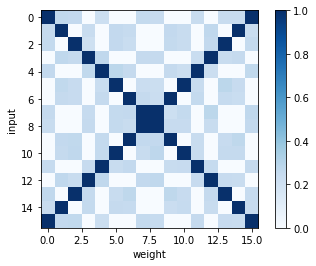

In [15]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
#ax.matshow(outcomes, cmap=plt.cm.Blues)
ax.set_xlabel("weight")
ax.set_ylabel("input")

out_plot = ax.imshow(outcomes, cmap='Blues', interpolation='none')
fig.colorbar(out_plot, ax=ax)

#fig.savefig('inputs_v_weights.png')